<a href="https://colab.research.google.com/github/saavedruky/IA_SISTEMAS_2024/blob/main/AdelineMulticapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

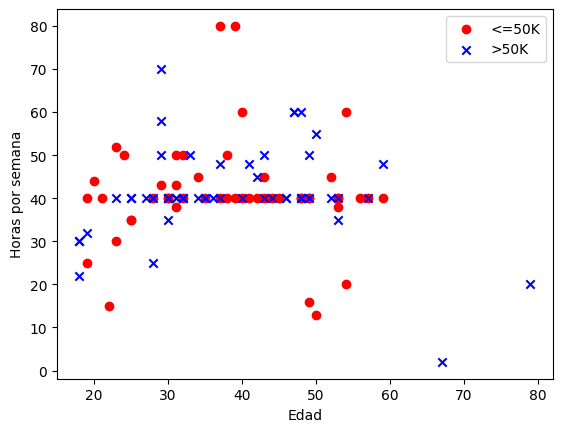

<ipython-input-3-83ec3091e6bd>:142: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx],


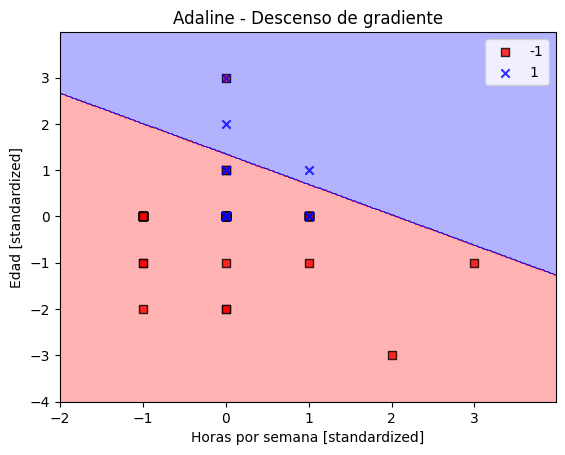

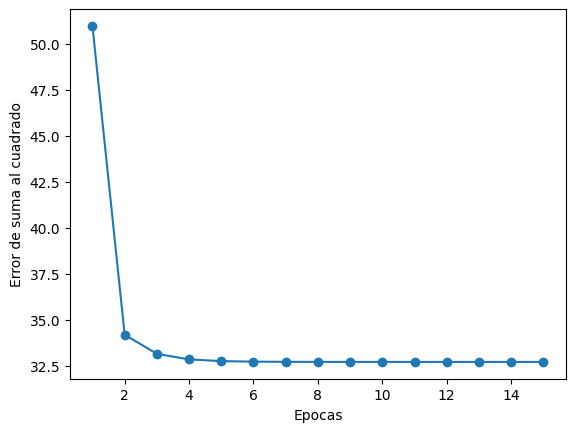

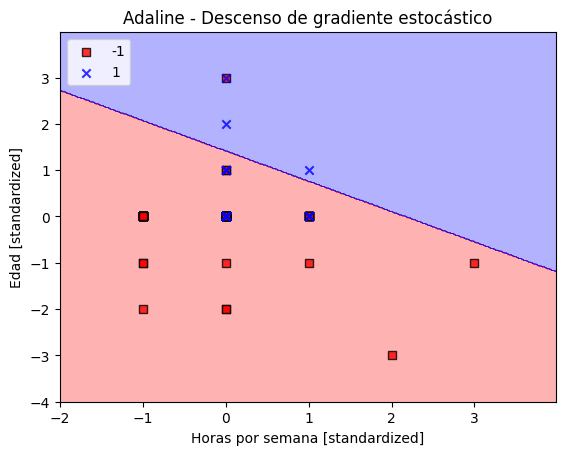

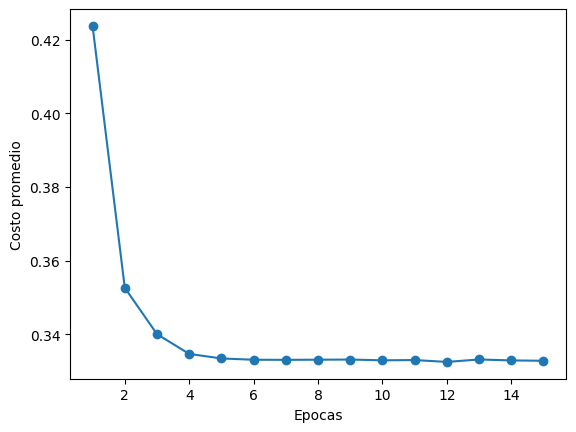

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Clase Perceptrón
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


# Clase AdalineGD (Descenso de Gradiente)
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


# Clase AdalineSGD (Descenso de Gradiente Estocástico)
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

# Función para visualizar las regiones de decisión
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

# Cargar el conjunto de datos (Adult dataset)
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)

# Preprocesar datos
y = df.iloc[0:100, 14].values
y = np.where(y == ' <=50K', -1, 1)
X = df.iloc[0:100, [0, 12]].values  # Edad y horas por semana

# Graficar los datos
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='<=50K')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='>50K')
plt.xlabel('Edad')
plt.ylabel('Horas por semana')
plt.legend(loc='upper right')
plt.show()

# Estándarizar las variables
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

# Adaline - Descenso de gradiente
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Descenso de gradiente')
plt.xlabel('Horas por semana [standardized]')
plt.ylabel('Edad [standardized]')
plt.legend(loc='upper right')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epocas')
plt.ylabel('Error de suma al cuadrado')
plt.show()

# Adaline - Descenso de gradiente estocástico
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Descenso de gradiente estocástico')
plt.xlabel('Horas por semana [standardized]')
plt.ylabel('Edad [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epocas')
plt.ylabel('Costo promedio')
plt.show()